<a href="https://colab.research.google.com/github/jayupad/nlp-adversarial-da/blob/main/cs371n_fp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial Cloning and Requirements

In [ ]:
!git clone https://github.com/gregdurrett/fp-dataset-artifacts.git
%cd fp-dataset-artifacts
!pip install -r requirements.txt
!pip install huggingface_hub
!pip install transformers
!pip install jsonlines

In [ ]:
!git config --global credential.helper store
!huggingface-cli login

# Modified Starter Code
Modified from https://github.com/gregdurrett/fp-dataset-artifacts

## Modified ```helpers.py```
Modified prepare_dataset_nli

In [ ]:
# Modified prepare_dataset_nli to add noisy and negated data
def prepare_dataset_nli(examples, tokenizer, max_seq_length=None, add_negated=False, add_noisy=False):
    max_seq_length = tokenizer.model_max_length if max_seq_length is None else max_seq_length

    tokenized_examples = tokenizer(
        examples['premise'],
        examples['hypothesis'],
        truncation=True,
        max_length=max_seq_length,
        padding='max_length'
    )

    tokenized_examples['label'] = examples['label']

    augmented_premises = []
    augmented_hypotheses = []
    augmented_labels = []

    # Function to negate a sentence
    def negate_sentence(sentence):
        if "not" in sentence:
            return sentence.replace("not ", "").replace(" not", "")
        else:
            words = sentence.split()
            words.insert(1, "not")  # Insert 'not' after the first word
            return " ".join(words)

    # Function to introduce misspellings
    def introduce_misspellings(sentence, n=2):
        words = sentence.split()
        for _ in range(n):
            word_idx = random.randint(0, len(words) - 1)
            char_idx = random.randint(0, len(words[word_idx]) - 1)
            if len(words[word_idx]) > 1:
                words[word_idx] = (
                    words[word_idx][:char_idx]
                    + random.choice('abcdefghijklmnopqrstuvwxyz')
                    + words[word_idx][char_idx + 1:]
                )
        return " ".join(words)

    # Function to introduce grammatical errors
    def introduce_grammar_errors(sentence):
        words = sentence.split()
        if len(words) > 2:
            # Swap the order of two adjacent words
            words[0], words[1] = words[1], words[0]
        return " ".join(words)

    if add_negated or add_noisy:
        for premise, hypothesis, label in zip(examples['premise'], examples['hypothesis'], examples['label']):
            if add_negated and label != 1:  # Negate only for entailment or contradiction
                negated_hypothesis = negate_sentence(hypothesis)
                augmented_premises.append(premise)
                augmented_hypotheses.append(negated_hypothesis)
                augmented_labels.append(2 - label)  # Flip entailment/contradiction

            if add_noisy:
                # Add misspellings
                noisy_premise = introduce_misspellings(premise)
                noisy_hypothesis = introduce_misspellings(hypothesis)
                augmented_premises.append(noisy_premise)
                augmented_hypotheses.append(noisy_hypothesis)
                augmented_labels.append(label)

                # Add grammatical errors
                noisy_premise = introduce_grammar_errors(premise)
                noisy_hypothesis = introduce_grammar_errors(hypothesis)
                augmented_premises.append(noisy_premise)
                augmented_hypotheses.append(noisy_hypothesis)
                augmented_labels.append(label)

    if augmented_premises:
        # Tokenize augmented examples
        augmented_tokenized = tokenizer(
            augmented_premises,
            augmented_hypotheses,
            truncation=True,
            max_length=max_seq_length,
            padding='max_length'
        )
        augmented_tokenized['label'] = augmented_labels

        # Combine original and augmented examples
        for key in tokenized_examples.keys():
            tokenized_examples[key] += augmented_tokenized[key]
    return tokenized_examples, len(augmented_premises)

## Modified ```run.py```
Added args for add_noisy and add_negated

In [ ]:
import datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, \
    AutoModelForQuestionAnswering, Trainer, TrainingArguments, HfArgumentParser
import evaluate
from helpers import prepare_dataset_nli, prepare_train_dataset_qa, \
    prepare_validation_dataset_qa, QuestionAnsweringTrainer, compute_accuracy
import os
import json

NUM_PREPROCESSING_WORKERS = 2


def main():
    argp = HfArgumentParser(TrainingArguments)
    # The HfArgumentParser object collects command-line arguments into an object (and provides default values for unspecified arguments).
    # In particular, TrainingArguments has several keys that you'll need/want to specify (when you call run.py from the command line):
    # --do_train
    #     When included, this argument tells the script to train a model.
    #     See docstrings for "--task" and "--dataset" for how the training dataset is selected.
    # --do_eval
    #     When included, this argument tells the script to evaluate the trained/loaded model on the validation split of the selected dataset.
    # --per_device_train_batch_size <int, default=8>
    #     This is the training batch size.
    #     If you're running on GPU, you should try to make this as large as you can without getting CUDA out-of-memory errors.
    #     For reference, with --max_length=128 and the default ELECTRA-small model, a batch size of 32 should fit in 4gb of GPU memory.
    # --num_train_epochs <float, default=3.0>
    #     How many passes to do through the training data.
    # --output_dir <path>
    #     Where to put the trained model checkpoint(s) and any eval predictions.
    #     *This argument is required*.

    argp.add_argument('--model', type=str,
                      default='google/electra-small-discriminator',
                      help="""This argument specifies the base model to fine-tune.
        This should either be a HuggingFace model ID (see https://huggingface.co/models)
        or a path to a saved model checkpoint (a folder containing config.json and pytorch_model.bin).""")
    argp.add_argument('--task', type=str, choices=['nli', 'qa'], required=True,
                      help="""This argument specifies which task to train/evaluate on.
        Pass "nli" for natural language inference or "qa" for question answering.
        By default, "nli" will use the SNLI dataset, and "qa" will use the SQuAD dataset.""")
    argp.add_argument('--dataset', type=str, default=None,
                      help="""This argument overrides the default dataset used for the specified task.""")
    argp.add_argument('--max_length', type=int, default=128,
                      help="""This argument limits the maximum sequence length used during training/evaluation.
        Shorter sequence lengths need less memory and computation time, but some examples may end up getting truncated.""")
    argp.add_argument('--max_train_samples', type=int, default=None,
                      help='Limit the number of examples to train on.')
    argp.add_argument('--max_eval_samples', type=int, default=None,
                      help='Limit the number of examples to evaluate on.')
    argp.add_argument('--add_negated', type=bool, default=False,
                      help='Add negated examples during training.')
    argp.add_argument('--add_noisy', type=bool, default=False,
                      help='Add misspelled and grammatically incorrect examples during training.')

    training_args, args = argp.parse_args_into_dataclasses()

    # Dataset selection
    # IMPORTANT: this code path allows you to load custom datasets different from the standard SQuAD or SNLI ones.
    # You need to format the dataset appropriately. For SNLI, you can prepare a file with each line containing one
    # example as follows:
    # {"premise": "Two women are embracing.", "hypothesis": "The sisters are hugging.", "label": 1}
    if args.dataset.endswith('.json') or args.dataset.endswith('.jsonl'):
        dataset_id = None
        # Load from local json/jsonl file
        dataset = datasets.load_dataset('json', data_files=args.dataset)
        # By default, the "json" dataset loader places all examples in the train split,
        # so if we want to use a jsonl file for evaluation we need to get the "train" split
        # from the loaded dataset
        eval_split = 'train'
    else:
        default_datasets = {'qa': ('squad',), 'nli': ('snli',)}
        dataset_id = tuple(args.dataset.split(':')) if args.dataset is not None else \
            default_datasets[args.task]
        # MNLI has two validation splits (one with matched domains and one with mismatched domains). Most datasets just have one "validation" split
        eval_split = 'validation_matched' if dataset_id == ('glue', 'mnli') else 'validation'
        # Load the raw data
        dataset = datasets.load_dataset(*dataset_id)

    # NLI models need to have the output label count specified (label 0 is "entailed", 1 is "neutral", and 2 is "contradiction")
    task_kwargs = {'num_labels': 3} if args.task == 'nli' else {}

    # Here we select the right model fine-tuning head
    model_classes = {'qa': AutoModelForQuestionAnswering,
                     'nli': AutoModelForSequenceClassification}
    model_class = model_classes[args.task]
    # Initialize the model and tokenizer from the specified pretrained model/checkpoint
    model = model_class.from_pretrained(args.model, **task_kwargs)
    # Make tensor contiguous if needed https://github.com/huggingface/transformers/issues/28293
    if hasattr(model, 'electra'):
        for param in model.electra.parameters():
            if not param.is_contiguous():
                param.data = param.data.contiguous()
    tokenizer = AutoTokenizer.from_pretrained(args.model, use_fast=True)

    # Select the dataset preprocessing function (these functions are defined in helpers.py)
    if args.task == 'qa':
        prepare_train_dataset = lambda exs: prepare_train_dataset_qa(exs, tokenizer)
        prepare_eval_dataset = lambda exs: prepare_validation_dataset_qa(exs, tokenizer)
    elif args.task == 'nli':
        prepare_train_dataset, extra_ct = prepare_eval_dataset, extra_ct = \
            lambda exs: prepare_dataset_nli(exs, tokenizer, args.max_length, args.add_negated)
        # prepare_eval_dataset = prepare_dataset_nli
    else:
        raise ValueError('Unrecognized task name: {}'.format(args.task))

    print("Preprocessing data... (this takes a little bit, should only happen once per dataset)")
    if dataset_id == ('snli',):
        # remove SNLI examples with no label
        dataset = dataset.filter(lambda ex: ex['label'] != -1)

    train_dataset = None
    eval_dataset = None
    train_dataset_featurized = None
    eval_dataset_featurized = None
    if training_args.do_train:
        train_dataset = dataset['train']
        if args.max_train_samples:
            train_dataset = train_dataset.select(range(args.max_train_samples))
        train_dataset_featurized = train_dataset.map(
            prepare_train_dataset,
            batched=True,
            num_proc=NUM_PREPROCESSING_WORKERS,
            remove_columns=train_dataset.column_names
        )
    if training_args.do_eval:
        eval_dataset = dataset[eval_split]
        if args.max_eval_samples:
            eval_dataset = eval_dataset.select(range(args.max_eval_samples))
        eval_dataset_featurized = eval_dataset.map(
            prepare_eval_dataset,
            batched=True,
            num_proc=NUM_PREPROCESSING_WORKERS,
            remove_columns=eval_dataset.column_names
        )

    # Select the training configuration
    trainer_class = Trainer
    eval_kwargs = {}
    # If you want to use custom metrics, you should define your own "compute_metrics" function.
    # For an example of a valid compute_metrics function, see compute_accuracy in helpers.py.
    compute_metrics = None
    if args.task == 'qa':
        # For QA, we need to use a tweaked version of the Trainer (defined in helpers.py)
        # to enable the question-answering specific evaluation metrics
        trainer_class = QuestionAnsweringTrainer
        eval_kwargs['eval_examples'] = eval_dataset
        metric = evaluate.load('squad')   # datasets.load_metric() deprecated
        compute_metrics = lambda eval_preds: metric.compute(
            predictions=eval_preds.predictions, references=eval_preds.label_ids)
    elif args.task == 'nli':
        compute_metrics = compute_accuracy


    # This function wraps the compute_metrics function, storing the model's predictions
    # so that they can be dumped along with the computed metrics
    eval_predictions = None
    def compute_metrics_and_store_predictions(eval_preds):
        nonlocal eval_predictions
        eval_predictions = eval_preds
        return compute_metrics(eval_preds)

    # Initialize the Trainer object with the specified arguments and the model and dataset we loaded above
    trainer = trainer_class(
        model=model,
        args=training_args,
        train_dataset=train_dataset_featurized,
        eval_dataset=eval_dataset_featurized,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_and_store_predictions
    )
    # Train and/or evaluate
    if training_args.do_train:
        trainer.train()
        trainer.save_model()
        # If you want to customize the way the loss is computed, you should subclass Trainer and override the "compute_loss"
        # method (see https://huggingface.co/transformers/_modules/transformers/trainer.html#Trainer.compute_loss).
        #
        # You can also add training hooks using Trainer.add_callback:
        #   See https://huggingface.co/transformers/main_classes/trainer.html#transformers.Trainer.add_callback
        #   and https://huggingface.co/transformers/main_classes/callback.html#transformers.TrainerCallback

    if training_args.do_eval:
        results = trainer.evaluate(**eval_kwargs)

        # To add custom metrics, you should replace the "compute_metrics" function (see comments above).
        #
        # If you want to change how predictions are computed, you should subclass Trainer and override the "prediction_step"
        # method (see https://huggingface.co/transformers/_modules/transformers/trainer.html#Trainer.prediction_step).
        # If you do this your custom prediction_step should probably start by calling super().prediction_step and modifying the
        # values that it returns.

        print('Evaluation results:')
        print(results)

        os.makedirs(training_args.output_dir, exist_ok=True)

        with open(os.path.join(training_args.output_dir, 'eval_metrics.json'), encoding='utf-8', mode='w') as f:
            json.dump(results, f)

        with open(os.path.join(training_args.output_dir, 'eval_predictions.jsonl'), encoding='utf-8', mode='w') as f:
            if args.task == 'qa':
                predictions_by_id = {pred['id']: pred['prediction_text'] for pred in eval_predictions.predictions}
                for example in eval_dataset:
                    example_with_prediction = dict(example)
                    example_with_prediction['predicted_answer'] = predictions_by_id[example['id']]
                    f.write(json.dumps(example_with_prediction))
                    f.write('\n')
            else:
                for i, example in enumerate(eval_dataset):
                    example_with_prediction = dict(example)
                    example_with_prediction['predicted_scores'] = eval_predictions.predictions[i].tolist()
                    example_with_prediction['predicted_label'] = int(eval_predictions.predictions[i].argmax())
                    f.write(json.dumps(example_with_prediction))
                    f.write('\n')


if __name__ == "__main__":
    main()

# Training and Analysis

## Comparing baseline ELECTRA-Small with fine-tuned model
This cell trains and runs the baseline and the fine-tuned model at different sample sizes to compare accuracy and loss

In [ ]:
import json
import os

num_samples = [10000, 20000, 30000, 40000, 50000, 110000]
res = {}


def train_and_run(model_name, output_name, res, samples, tune):

  # !python3 run.py --do_train --task nli --dataset snli --output_dir ./$model_name --add_negated $tune --add_noisy $tune --max_train_samples $samples
  !python3 run.py --model $model_name --do_eval --task nli --dataset snli --output_dir $output_name
  metrics = f"{output_name}/eval_metrics.json"
  if os.path.exists(metrics):
    with open(f"{output_name}/eval_metrics.json", "r") as f:
        curr = json.load(f)
        loss = curr['eval_loss']
        accuracy = curr['eval_accuracy']
        time = curr['eval_runtime']
    res[model_name] = (loss, accuracy, time)


for i in num_samples:
  base_model_name = f"base_model{str(int(i / 1000))}"
  base_output_name = f"{base_model_name}_out"

  train_and_run(base_model_name, base_output_name, res, i, False)

  tuned_model_name = f"tuned_model{str(int(i / 1000))}"
  tuned_output_name = f"{tuned_model_name}_out"

  train_and_run(tuned_model_name, tuned_output_name, res, i, True)

# !python3 run.py --do_train --task nli --dataset snli --output_dir ./test_out_10 --max_train_samples 10000
# !python3 run.py --do_train --task nli --dataset snli --output_dir ./test_out_20 --max_train_samples 20000
# !python3 run.py --model test_out_10 --do_eval --task nli --dataset snli --output_dir tuned_output_10
# !python3 run.py --model test_out_20 --do_eval --task nli --dataset snli --output_dir tuned_output_20

In [ ]:
!python3 run.py --model base_model_110k --do_eval --task nli --dataset snli --output_dir base110k_output

## Compare ELECTRA and Tuned Model on 50 examples
Randomly select 50 examples from SNLI, and apply noise/negation to them. Then, run both models on each and tally accuracy

In [ ]:
from datasets import load_dataset

# Load the SNLI dataset
snli = load_dataset("snli")
train_data = snli['train']
# Get the first 50 examples
random_indices = np.random.choice(len(train_data), 50, replace=False)
random_50_examples = [train_data[i] for i in random_indices]


# Convert the dictionary of lists into a list of dictionaries
examples = [{key: random_50_examples[key][i] for key in random_50_examples} for i in range(len(random_50_examples['premise']))]
# print(examples[0])
# Print the examples
for idx, example in enumerate(examples):
    print(f"Example {idx + 1}:")
    print(f"  Premise: {example['premise']}")
    print(f"  Hypothesis: {example['hypothesis']}")
    print(f"  Label: {example['label']}")
    print()


In [ ]:
import random
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd

random.seed(42)
def misspell_sentence(sentence, n=2):
  words = sentence.split()
  for _ in range(n):
    word_idx = random.randint(0, len(words) - 1)
    char_idx = random.randint(0, len(words[word_idx]) - 1)
    # char_idx1, char_idx2 = random.sample(range(len(words)), 2)
    # char_idx1, char_idx2 = min(char_idx1, char_idx2), max(char_idx1, char_idx2)
    if len(words[word_idx]) > 1:
      words[word_idx] = (
          words[word_idx][:char_idx]
          + random.choice('abcdefghijklmnopqrstuvwxyz')
          + random.choice('abcdefghijklmnopqrstuvwxyz')
          + words[word_idx][char_idx + 1:]
      )
  return " ".join(words)

def introduce_grammar_errors(sentence):
  words = sentence.split()
  if len(words) > 2:
    idx1 = random.sample(range(len(words) - 1), 1)[0]
    idx2 += 1
    words[idx1], words[idx2] = words[idx2], words[idx1]
  return " ".join(words)

def negate_sentence(sentence):
  if "not" in sentence:
    return sentence.replace("not ", "").replace(" not", "")
  else:
    words = sentence.split()
    words.insert(1, "not")  # Insert 'not' after the first word
    return " ".join(words)

# Load the pretrained Electra-small model and tokenizer
model_path = "tuned_model_110k/"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load your 50 SNLI examples
# Each example should be a dictionary with 'premise', 'hypothesis', and 'label' keys
# For demonstration purposes, here's a placeholder:
original_examples = examples

# Create perturbed examples
negated_examples = []
misspelled_examples = []
grammatical_examples = []

for example in original_examples:
    # Negated example
    negated_hypothesis = negate_sentence(example['hypothesis'])
    negated_examples.append({
        'premise': example['premise'],
        'hypothesis': negated_hypothesis,
        'label': 2 - example['label'] # flip label
    })

    # Misspelled example
    misspelled_hypothesis = misspell_sentence(example['hypothesis'])
    misspelled_examples.append({
        'premise': example['premise'],
        'hypothesis': misspelled_hypothesis,
        'label': example['label']
    })

    # Grammatically incorrect example
    grammatical_hypothesis = introduce_grammar_errors(example['hypothesis'])
    grammatical_examples.append({
        'premise': example['premise'],
        'hypothesis': grammatical_hypothesis,
        'label': example['label']
    })

def predict_examples(examples, model, tokenizer):
    predictions = []
    true_labels = []
    for ex in examples:
        inputs = tokenizer(
            ex['premise'], ex['hypothesis'],
            return_tensors='pt',
            truncation=True,
            padding=True
        ).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_label = torch.argmax(logits, dim=1).cpu().item()
            predictions.append(predicted_label)
            true_labels.append(ex['label'])
    return predictions, true_labels

original_predictions, original_true_labels = predict_examples(original_examples, model, tokenizer)

negated_predictions, negated_true_labels = predict_examples(negated_examples, model, tokenizer)

misspelled_predictions, misspelled_true_labels = predict_examples(misspelled_examples, model, tokenizer)

grammatical_predictions, grammatical_true_labels = predict_examples(grammatical_examples, model, tokenizer)

# Function to calculate accuracy
def calculate_accuracy(predictions, true_labels):
    correct = sum([1 for pred, true in zip(predictions, true_labels) if pred == true])
    accuracy = correct / len(true_labels)
    return accuracy

# Calculate accuracies
original_accuracy = calculate_accuracy(original_predictions, original_true_labels)
negated_accuracy = calculate_accuracy(negated_predictions, negated_true_labels)
misspelled_accuracy = calculate_accuracy(misspelled_predictions, misspelled_true_labels)
grammatical_accuracy = calculate_accuracy(grammatical_predictions, grammatical_true_labels)

print(f"Accuracy on Original Examples: {original_accuracy * 100:.2f}%")
print(f"Accuracy on Negated Examples: {negated_accuracy * 100:.2f}%")
print(f"Accuracy on Misspelled Examples: {misspelled_accuracy * 100:.2f}%")
print(f"Accuracy on Grammatically Incorrect Examples: {grammatical_accuracy * 100:.2f}%")

# Separate cases and generate classification reports
# def get_classification_report(predictions, true_labels):
#     from sklearn.metrics import classification_report
#     target_names = ['entailment', 'neutral', 'contradiction']
#     report = classification_report(true_labels, predictions, target_names=target_names, zero_division=0)
#     return report

# print("\nClassification Report on Original Examples:")
# print(get_classification_report(original_predictions, original_true_labels))

# print("\nClassification Report on Negated Examples:")
# print(get_classification_report(negated_predictions, negated_true_labels))

# print("\nClassification Report on Misspelled Examples:")
# print(get_classification_report(misspelled_predictions, misspelled_true_labels))

# print("\nClassification Report on Grammatically Incorrect Examples:")
# print(get_classification_report(grammatical_predictions, grammatical_true_labels))


## Generate Confusion Matrices
Extract gold and predicted labels and calculate metrics

In [ ]:
import jsonlines
def extract_labels(jsonl_file):
    gold_labels = []
    predicted_labels = []

    # Open the JSONL file
    with jsonlines.open(jsonl_file) as reader:
        for obj in reader:
            # Append gold and predicted labels to respective lists
            gold_labels.append(obj['label'])
            predicted_labels.append(obj['predicted_label'])
    return gold_labels, predicted_labels

# Example usage
jsonl_file = 'base110k_output/eval_predictions.jsonl'
gold_labels, predicted_labels = extract_labels(jsonl_file)

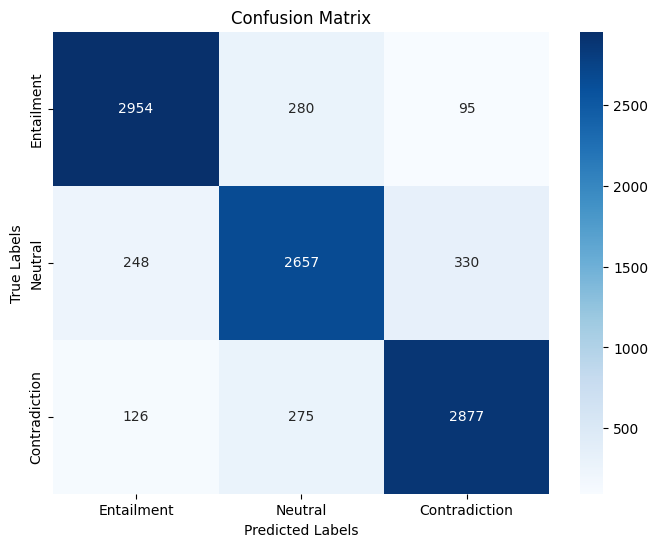

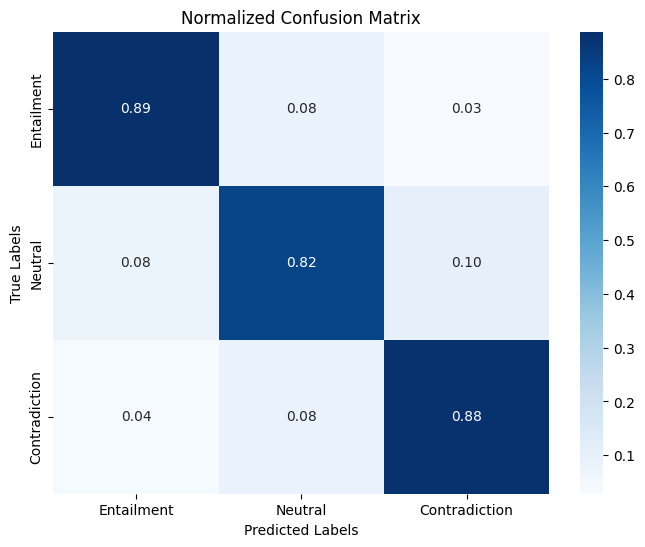

Classification Report:

               precision    recall  f1-score   support

   Entailment     0.8876    0.8874    0.8875      3329
      Neutral     0.8272    0.8213    0.8243      3235
Contradiction     0.8713    0.8777    0.8745      3278

     accuracy                         0.8624      9842
    macro avg     0.8620    0.8621    0.8621      9842
 weighted avg     0.8623    0.8624    0.8624      9842



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Label names for SNLI
label_names = ['Entailment', 'Neutral', 'Contradiction']

# Create confusion matrix
cm = confusion_matrix(gold_labels, predicted_labels)

# Normalize confusion matrix (optional)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
def plot_confusion_matrix(cm, labels, title='Confusion Matrix', normalize=False):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# Plot raw confusion matrix
plot_confusion_matrix(cm, label_names, title='Confusion Matrix')

# Plot normalized confusion matrix
plot_confusion_matrix(cm_normalized, label_names, title='Normalized Confusion Matrix', normalize=True)

# Classification report
report = classification_report(gold_labels, predicted_labels, target_names=label_names, digits=4)
print("Classification Report:\n")
print(report)


## Miscellaneous Functions

### Push model to HuggingFace

In [ ]:
from huggingface_hub import HfApi, HfFolder, Repository
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_dir = # directory
repo_id = "jayupad/electra-small-trained"

# Login to Hugging Face (if not already authenticated)
# !huggingface-cli login
model = AutoModelForSequenceClassification.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)

# Push to the Hugging Face Hub
model.push_to_hub(repo_id)
tokenizer.push_to_hub(repo_id)

print("Model and tokenizer have been pushed to Hugging Face!")


### Zip and Download model without checkpoints

In [ ]:
import os
import zipfile
from google.colab import files

def zip_folder_without_subfolders(folder_path, output_zip_path):
    with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)
            if os.path.isfile(item_path):  # Only include files, not directories
                zipf.write(item_path, arcname=item)

# Specify the folder and output zip file name
folder_to_zip = 'tuned_model110k'  # Change to your folder path
output_zip = 'tuned_model_110k.zip'

# Ensure the folder exists
if not os.path.exists(folder_to_zip):
    print(f"Folder {folder_to_zip} does not exist. Please create it and add files.")
else:
    # Zip the folder without including subfolders
    zip_folder_without_subfolders(folder_to_zip, output_zip)
    print(f"Zipped {folder_to_zip} into {output_zip} without subfolders.")

    # Download the zipped file
    files.download(output_zip)


Zipped tuned_model110k into tuned_model_110k.zip without subfolders.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>